In [1]:
# Import packages
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
%run C:/Users/siebe/Documents/JT_Charts.ipynb

ps = PorterStemmer()
stopwords_english = set(stopwords.words('english'))

In [2]:
# Corpus
## Chinese newspapers
china_daily=pd.read_csv('China Daily.csv')
people_daily=pd.read_csv('People\'s Daily.csv')
xinhua_agent=pd.read_csv('Xinhua Agent.csv')

def corpus_create(news, val):
    news = news.drop(['title'], axis=1)
    news = news.dropna(how='all')
    news['newspaper'] = val
    return news

china_daily = corpus_create(china_daily, 'China Daily')
people_daily = corpus_create(people_daily, 'People\'s Daily')
xinhua_agent = corpus_create(xinhua_agent, 'Xinhua Agent')

corpus=pd.concat([china_daily, people_daily, xinhua_agent],axis=0,ignore_index=True)

corpus.head()

,text,newspaper
0,Policeman hospitalized with leg burns; large g...,China Daily
1,It's a reflection of Bruce Lee's transcendent ...,China Daily
2,Experts say it's harder to lure overseas talen...,China Daily
3,There is a dreary dismal familiarity to me in ...,China Daily
4,Editor's Note: The US Congress has made the pa...,China Daily


In [3]:
# Balance
corpus['newspaper'].value_counts()

Xinhua Agent      235
China Daily       167
People's Daily    147
Name: newspaper, dtype: int64

In [4]:
keywords = ["\'s", "china daily", "people daily", "xinhua", 
            "wall street journal", "new york times", "washington post",
           "editorial", "commentary"]

# Case removal, non-alpha removal, keyword removal, and stemming
corpus['text'] = corpus['text'].str.split()
corpus['text'] = corpus['text'].apply(lambda x: [re.sub(r'[^a-zA-Z]', "",y.lower()) for y in x])
corpus['text'] = corpus['text'].apply(lambda x: [y for y in x if y not in keywords])
corpus['text'] = corpus['text'].apply(lambda x: [ps.stem(y) for y in x])
corpus['text'] = corpus['text'].apply(lambda x: [' '.join(x)])
corpus['text'] = pd.Series(corpus['text']).astype(str)
corpus.head()

,text,newspaper
0,['policeman hospit with leg burn larg group of...,China Daily
1,['it a reflect of bruce lee transcend appeal t...,China Daily
2,['expert say it harder to lure oversea talent ...,China Daily
3,['there is a dreari dismal familiar to me in w...,China Daily
4,['editor note the us congress ha made the pass...,China Daily


In [5]:
# Split data

# Separate features and target
corpus_text = corpus.iloc[:,0]
corpus_classes = corpus.iloc[:,1]

# split the dataset into training and validation datasets 
x_train, x_test, y_train, y_test = train_test_split(corpus_text, corpus_classes, 
                                                    test_size=0.3, stratify=corpus_classes)
print(x_train.head())

517    ['peopl attend a flagrais ceremoni at the wong...
193    ['baku aug   the ongo violenc in hong kong cou...
28     ['the govern of the hong kong special administ...
108    ['some  resid in the hong kong special adminis...
249    ['wong kamleung right chairman of the hong kon...
Name: text, dtype: object


In [6]:
# label encode the target variable 
labels = preprocessing.LabelEncoder()
y_train = labels.fit_transform(y_train)
y_test = labels.fit_transform(y_test)
labels.classes_

# Create document term matrices
### Create binary DTM in which words present in doc receive value of one
### Create term frequency DTM to emphasize most commonly used words
### Create TF-IDF DTM to emphasize words most specific to each document

In [7]:
# Create Unigram, Binary DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 1), binary=True) 
vectorizer.fit(x_train)
binary1_train = vectorizer.transform(x_train)
binary1_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(binary1_train.toarray()) 

Count of terms 2411
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
# Create Bigram, Binary DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 2), binary=True) 
vectorizer.fit(x_train)
binary2_train = vectorizer.transform(x_train)
binary2_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(binary2_train.toarray()) 

Count of terms 4677
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
# Create Trigram, Binary DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 3), binary=True) 
vectorizer.fit(x_train)
binary3_train = vectorizer.transform(x_train)
binary3_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(binary3_train.toarray()) 

Count of terms 5740
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [10]:
# Create Unigram, Term Frequency DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 1)) 
vectorizer.fit(x_train)
tf1_train = vectorizer.transform(x_train)
tf1_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tf1_train.toarray()) 

Count of terms 2411
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
# Create Bigram, Term Frequency DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 2)) 
vectorizer.fit(x_train)
tf2_train = vectorizer.transform(x_train)
tf2_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tf2_train.toarray()) 

Count of terms 4677
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
# Create Trigram, Term Frequency DTM
vectorizer = CountVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 3)) 
vectorizer.fit(x_train)
tf3_train = vectorizer.transform(x_train)
tf3_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tf3_train.toarray()) 

Count of terms 5740
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [13]:
# Create Unigram, TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 1))
vectorizer.fit(x_train)
tfidf1_train = vectorizer.transform(x_train)
tfidf1_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tfidf1_train.toarray()) 

Count of terms 2411
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
# Create Bigram, TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 2))
vectorizer.fit(x_train)
tfidf2_train = vectorizer.transform(x_train)
tfidf2_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tfidf2_train.toarray()) 

Count of terms 4677
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
# Create Trigram, TF-IDF DTM
vectorizer = TfidfVectorizer(stop_words='english', min_df=int(5), max_df=0.9, ngram_range=(1, 3))
vectorizer.fit(x_train)
tfidf3_train = vectorizer.transform(x_train)
tfidf3_test = vectorizer.transform(x_test)

print("Count of terms", len(vectorizer.get_feature_names()))
print(tfidf3_train.toarray())

Count of terms 5740
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Model nine configurations in a loop

In [16]:
# Define model training
def train_model(dtm, test):
    # model the training data
    clf.fit(dtm, y_train)
    
    # predictions on the test data
    preds = clf.predict(test)
    
    # print metrics
    print("Accuracy:", '{:1.4f}'.format(accuracy_score(y_test, preds)))
    print("")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    
    return '{:1.4f}'.format(accuracy_score(y_test, preds))

In [17]:
# Use Naive Bayes
clf = XGBClassifier() #MultinomialNB()

# Model Configurations
binary1 = ("unigram, binary", binary1_train, binary1_test)
binary2 = ("bigram, binary",  binary2_train, binary2_test)
binary3 = ("trigram, binary", binary3_train, binary3_test)
tf1 = ("unigram, TF", tf1_train, tf1_test)
tf2 = ("bigram, TF",  tf2_train, tf2_test)
tf3 = ("trigram, TF", tf3_train, tf3_test)
tfidf1 = ("unigram, TF-IDF", tfidf1_train, tfidf1_test)
tfidf2 = ("bigram, TF-IDF",  tfidf2_train, tfidf2_test)
tfidf3 = ("trigram, TF-IDF", tfidf3_train, tfidf3_test)
DTMs = [binary1, binary2, binary3,
        tf1, tf2, tf3,
        tfidf1, tfidf2, tfidf3]

df = pd.DataFrame({"config": [],
                   "accuracy": []})
best_config = ["Best Configuration", "none", 0, "none", "none"]
for data in DTMs:
    print(data[0])
    print("")
    score = train_model(data[1], data[2])
    print("======================================================")
    print("")
    if float(score) > float(best_config[2]):
        best_config = ["Best Configuration:", data[0], score, data[1], data[2]]
    df = df.append({"config": data[0],
               "accuracy": float(score)},
               ignore_index=True)

unigram, binary

Accuracy: 0.7152

              precision    recall  f1-score   support

           0       0.91      0.84      0.87        50
           1       0.51      0.48      0.49        44
           2       0.71      0.77      0.74        71

    accuracy                           0.72       165
   macro avg       0.71      0.70      0.70       165
weighted avg       0.72      0.72      0.71       165

Confusion Matrix:
[[42  5  3]
 [ 3 21 20]
 [ 1 15 55]]

bigram, binary

Accuracy: 0.7152

              precision    recall  f1-score   support

           0       0.91      0.86      0.89        50
           1       0.51      0.43      0.47        44
           2       0.69      0.79      0.74        71

    accuracy                           0.72       165
   macro avg       0.71      0.69      0.70       165
weighted avg       0.71      0.72      0.71       165

Confusion Matrix:
[[43  4  3]
 [ 3 19 22]
 [ 1 14 56]]

trigram, binary

Accuracy: 0.7091

              precisio

In [18]:
# Each model's result
df

,config,accuracy
0,"unigram, binary",0.7152
1,"bigram, binary",0.7152
2,"trigram, binary",0.7091
3,"unigram, TF",0.6848
4,"bigram, TF",0.6970
5,"trigram, TF",0.7212
6,"unigram, TF-IDF",0.6788
7,"bigram, TF-IDF",0.7152
8,"trigram, TF-IDF",0.6970


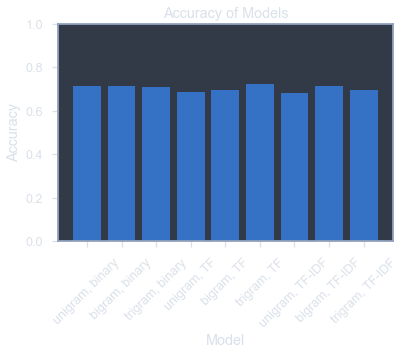

In [37]:
# Create plot
plt.figure()

# Create plot title
plt.title("Accuracy of Models")

# Add bars
plt.bar(range(df.shape[0]), df['accuracy'])
plt.yticks([0,.2,.4,.6,.8,1]) 
plt.ylabel('Accuracy')

# Add feature names as x-axis labels
plt.xticks(range(df.shape[0]), df['config'], rotation=45)
plt.xlabel('Model')

# Show plot
plt.show()

In [20]:
# Best Configuration
print(best_config)

['Best Configuration:', 'trigram, TF', '0.7212', <384x5740 sparse matrix of type '<class 'numpy.int64'>'
	with 96748 stored elements in Compressed Sparse Row format>, <165x5740 sparse matrix of type '<class 'numpy.int64'>'
	with 35587 stored elements in Compressed Sparse Row format>]


In [21]:
# Best Configuration
clf.fit(best_config[3], y_train)

# predictions on the test data
preds = clf.predict(best_config[4])

# feature importance
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [vectorizer.get_feature_names()[i] for i in indices]

In [22]:
# Main features
names[0:50]

['credit',
 'china daili',
 'special',
 'sept',
 'sar',
 'restor',
 'extradit',
 'foreign polici',
 'law amend',
 'railway mtr',
 'aug',
 'citi',
 'despit',
 'administr region hksar',
 'ensur',
 'minist',
 'problem hong',
 'howev',
 'committe',
 'demonstr hong',
 'life hong',
 'photo',
 'effect',
 'carri lam cheng',
 'resid',
 'li',
 'attack',
 'administr',
 'thi',
 'offici',
 'provid',
 'posit',
 'govern depart',
 'carri lam',
 'longer',
 'polic said',
 'local time',
 'administr region sar',
 'shame',
 'violenc restor',
 'china',
 'difficult',
 'said',
 'emblem',
 'hong kong sept',
 'south china',
 'china hong',
 'cite',
 'result',
 'latest']

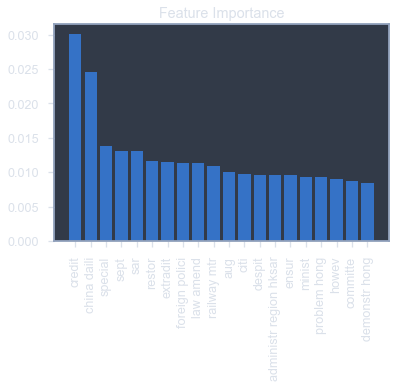

In [39]:
num_features = 20

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(num_features), importances[indices][0:num_features])

# Add feature names as x-axis labels
plt.xticks(range(num_features), names[0:num_features], rotation=90)

# Show plot
plt.show()